In [10]:
#Incluya las principales librerias a utilizar
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

In [12]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

# Data Final

| **Columna**     | **Significado**                                                                                                                                      |
| --------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------- |
| `open`          | Precio de apertura del día: primer precio al que se negoció CFG en la jornada.                                                                       |
| `high`          | Precio máximo del día: valor más alto alcanzado durante la sesión de trading.                                                                        |
| `low`           | Precio mínimo del día: valor más bajo alcanzado durante la sesión de trading.                                                                        |
| `close`         | Precio de cierre del día: último precio registrado al finalizar la jornada (marca el valor de referencia para el siguiente día).                     |
| `timestamp`     | Fecha y hora en que se registró el precio de cierre (en formato UTC).                                                                                |
| `volume_log`    | Volumen de transacciones diario transformado con `log1p` (log(1 + volumen)) para reducir sesgos y escala del dato original.                          |
| `marketCap_log` | Capitalización de mercado diaria transformada con `log1p` (log(1 + marketCap)) para homogeneizar la escala y atenuar el impacto de valores extremos. |


# Cargar datos y explorar

In [59]:
df = pd.read_csv('C:/Users/ASUS/TP-TF-Machine-Learning/Data/new_data.csv')

In [60]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [61]:
df = df.set_index('timestamp').sort_index()

# Features temporales y return

In [62]:
def create_features_ST(df):
    df = df.copy()
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df["quarter"] = df.index.quarter
    return df

In [63]:
df = create_features_ST(df)

In [64]:
df['return'] = df['close'].pct_change()

In [65]:
df['target'] = df['close']

# Lags y rolling means

In [66]:
for lag in range(1, 8):
    df[f'lag_{lag}'] = df['target'].shift(lag)

In [67]:
df['rolling_mean_3'] = df['target'].rolling(window=3).mean()
df['rolling_mean_7'] = df['target'].rolling(window=7).mean()

In [68]:
df = df.dropna()

# Selección de features y train/test split 

In [70]:
features = [
    'open', 'high', 'low', 'volume_log', 'marketCap_log', 
    'year', 'month', 'day', 'day_of_week', 'quarter', 
    'return',
    'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7',
    'rolling_mean_3', 'rolling_mean_7'
]

In [71]:
X = df[features]
y = df['target']

Division temporal (Ultimo 20% como test)

In [72]:
split_idx = int(len(df) * 0.8)

In [73]:
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Metricas

In [77]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [78]:
def evaluate(y_true, y_pred, name="Modelo"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    return mae, rmse, r2

# Modelos Clasicos

In [261]:
results = []

## LightGBM

In [79]:
from lightgbm import LGBMRegressor

In [81]:
model_lgbm = LGBMRegressor()

In [82]:
model_lgbm.fit(X_train, y_train)

LGBMRegressor()

In [83]:
y_pred_lgbm = model_lgbm.predict(X_test)

In [262]:
mae, rmse, r2 = evaluate(y_test, y_pred_lgbm, "LightGBM")
results.append({"name": "LightGBM", "MAE": mae, "RMSE": rmse, "R2": r2})


LightGBM
MAE:  0.0095
RMSE: 0.0135
R²:   0.9807


## XGBoost

In [85]:
import xgboost as xgb

In [86]:
model_xgb = xgb.XGBRegressor()

In [87]:
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [88]:
y_pred_xgb = model_xgb.predict(X_test)

In [263]:
mae, rmse, r2 = evaluate(y_test, y_pred_xgb, "XGBoost")
results.append({"name": "XGBoost", "MAE": mae, "RMSE": rmse, "R2": r2})


XGBoost
MAE:  0.0090
RMSE: 0.0123
R²:   0.9840


## CatBoost

In [92]:
from catboost import CatBoostRegressor

In [93]:
model_cat = CatBoostRegressor(verbose=0)

In [94]:
model_cat.fit(X_train, y_train)

In [95]:
y_pred_cat = model_cat.predict(X_test)

In [264]:
mae, rmse, r2 = evaluate(y_test, y_pred_cat, "CatBoost")
results.append({"name": "CatBoost", "MAE": mae, "RMSE": rmse, "R2": r2})


CatBoost
MAE:  0.0208
RMSE: 0.0250
R²:   0.9341


## Random Forest

In [97]:
from sklearn.ensemble import RandomForestRegressor

In [98]:
model_rf = RandomForestRegressor()

In [99]:
model_rf.fit(X_train, y_train)

RandomForestRegressor()

In [100]:
y_pred_rf = model_rf.predict(X_test)

In [265]:
mae, rmse, r2 = evaluate(y_test,y_pred_rf, "Random Forest")
results.append({"name": "Random Forest", "MAE": mae, "RMSE": rmse, "R2": r2})


Random Forest
MAE:  0.0090
RMSE: 0.0124
R²:   0.9839


## Gradient Boosting

In [102]:
from sklearn.ensemble import GradientBoostingRegressor

In [103]:
model_gb = GradientBoostingRegressor()

In [104]:
model_gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [105]:
y_pred_gb = model_gb.predict(X_test)

In [266]:
mae, rmse, r2 = evaluate(y_test, y_pred_gb, "Gradient Boosting")
results.append({"name": "Gradient Boosting", "MAE": mae, "RMSE": rmse, "R2": r2})


Gradient Boosting
MAE:  0.0079
RMSE: 0.0112
R²:   0.9867


## Prophet

In [127]:
from prophet import Prophet

In [128]:
df_prophet = y_train.reset_index()
df_prophet.columns = ['ds', 'y']

In [133]:
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.tz_localize(None)

In [134]:
m = Prophet()

In [135]:
m.fit(df_prophet)

22:40:30 - cmdstanpy - INFO - Chain [1] start processing
22:40:30 - cmdstanpy - INFO - Chain [1] done processing


In [136]:
future = m.make_future_dataframe(periods=len(y_test), freq='D')

In [137]:
forecast = m.predict(future)

In [138]:
y_pred_prophet = forecast.iloc[-len(y_test):]['yhat'].values

In [267]:
mae, rmse, r2 = evaluate(y_test, y_pred_prophet, "Prophet")
results.append({"name": "Prophet", "MAE": mae, "RMSE": rmse, "R2": r2})


Prophet
MAE:  0.1330
RMSE: 0.1724
R²:   -2.1311


## Arima

In [152]:
from statsmodels.tsa.arima.model import ARIMA

In [155]:
model_arima = sm.tsa.ARIMA(y_train, order=(5,1,0))

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [156]:
model_arima_fit = model_arima.fit()

In [157]:
start = len(y_train)

In [158]:
end = start + len(y_test) - 1

In [159]:
y_pred_arima = model_arima_fit.predict(start=start, end=end)

In [268]:
mae, rmse, r2 = evaluate(y_test, y_pred_arima, "ARIMA")
results.append({"name": "ARIMA", "MAE": mae, "RMSE": rmse, "R2": r2})


ARIMA
MAE:  0.1172
RMSE: 0.1402
R²:   -1.0700


## Sarima

In [162]:
import statsmodels.api as sm

In [163]:
model_sarima = sm.tsa.SARIMAX(
    y_train,
    order=(1,1,1),
    seasonal_order=(1,1,1,12)
)

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [164]:
model_sarima_fit = model_sarima.fit(disp=False)

In [165]:
y_pred_sarima = model_sarima_fit.forecast(steps=len(y_test))

In [269]:
mae, rmse, r2 = evaluate(y_test, y_pred_sarima, "SARIMA")
results.append({"name": "SARIMA", "MAE": mae, "RMSE": rmse, "R2": r2})


SARIMA
MAE:  0.0625
RMSE: 0.0771
R²:   0.3734


## Exponential Smoothing (Holt-Winters)

In [168]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [169]:
model_hw = ExponentialSmoothing(
    y_train,
    seasonal='add',
    seasonal_periods=12
)


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [170]:
model_hw_fit = model_hw.fit()

In [171]:
y_pred_hw = model_hw_fit.forecast(steps=len(y_test))

In [270]:
mae, rmse, r2 = evaluate(y_test, y_pred_hw, "Holt-Winters")
results.append({"name": "Holt-Winters", "MAE": mae, "RMSE": rmse, "R2": r2})


Holt-Winters
MAE:  0.1156
RMSE: 0.1384
R²:   -1.0183


## Theta Model

In [174]:
from statsmodels.tsa.forecasting.theta import ThetaModel

In [175]:
theta = ThetaModel(y_train, period=12)

In [176]:
theta_fit = theta.fit()

In [177]:
y_pred_theta = theta_fit.forecast(steps=len(y_test))

In [271]:
mae, rmse, r2 = evaluate(y_test, y_pred_theta, "Theta Model")
results.append({"name": "Theta Model", "MAE": mae, "RMSE": rmse, "R2": r2})


Theta Model
MAE:  0.0992
RMSE: 0.1189
R²:   -0.4881


# Graficos para cada modelo

In [107]:
def plot_predictions(y_test, y_pred, name):
    plt.figure(figsize=(16,5))
    plt.plot(y_test.index, y_test, label='Real', color='black')
    plt.plot(y_test.index, y_pred, label='Predicho', linestyle='--')
    plt.title(f"Real vs Predicho - {name}")
    plt.xlabel("Tiempo")
    plt.ylabel("Close")
    plt.legend()
    plt.grid()
    plt.show()


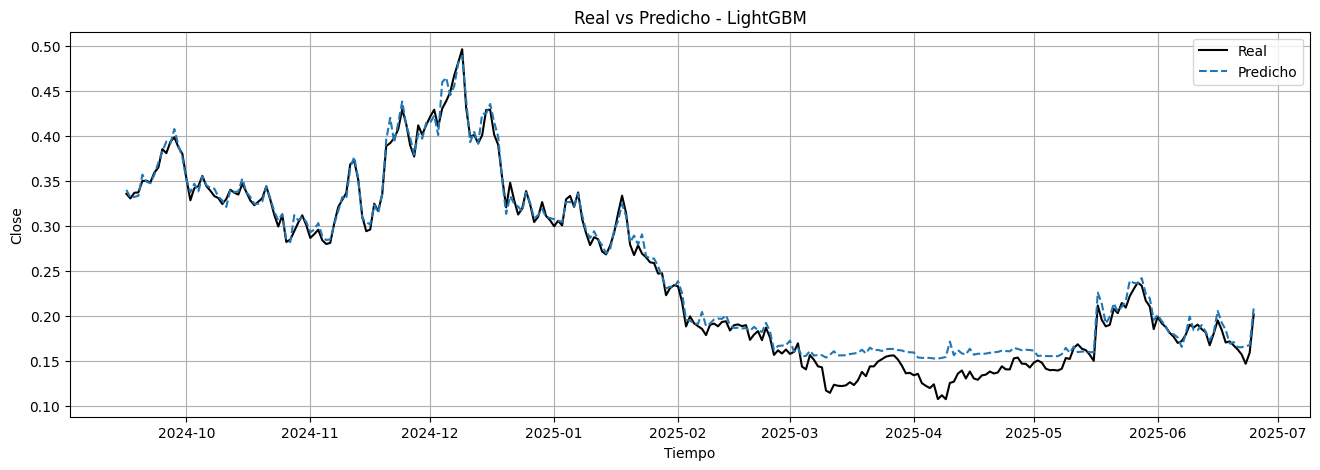

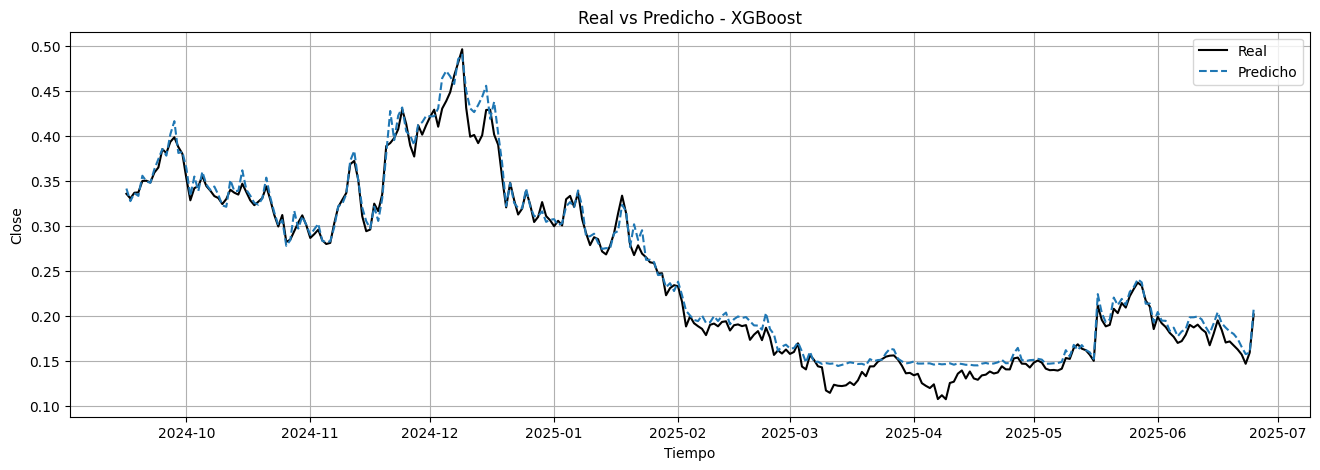

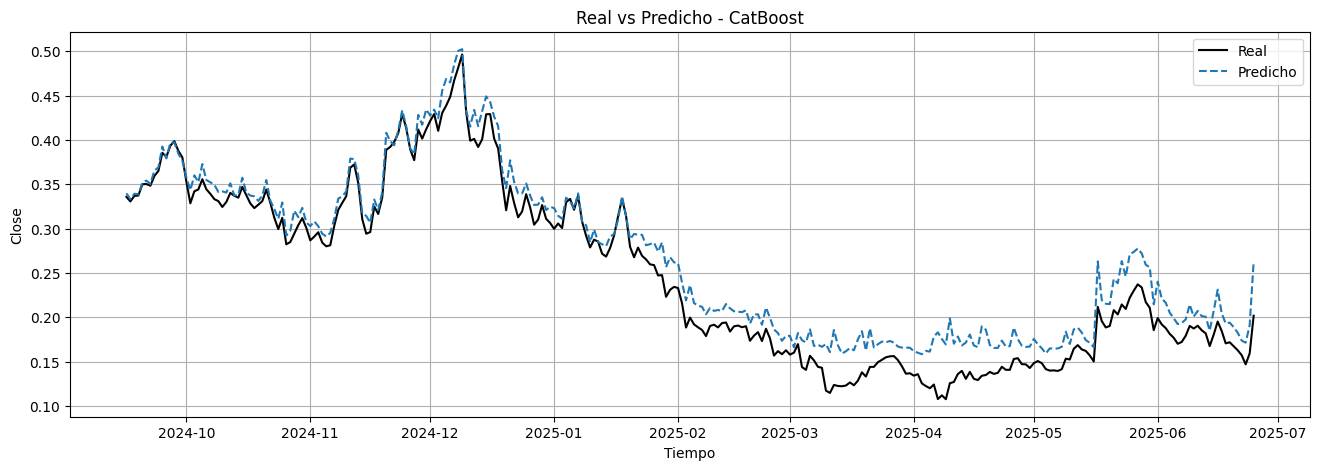

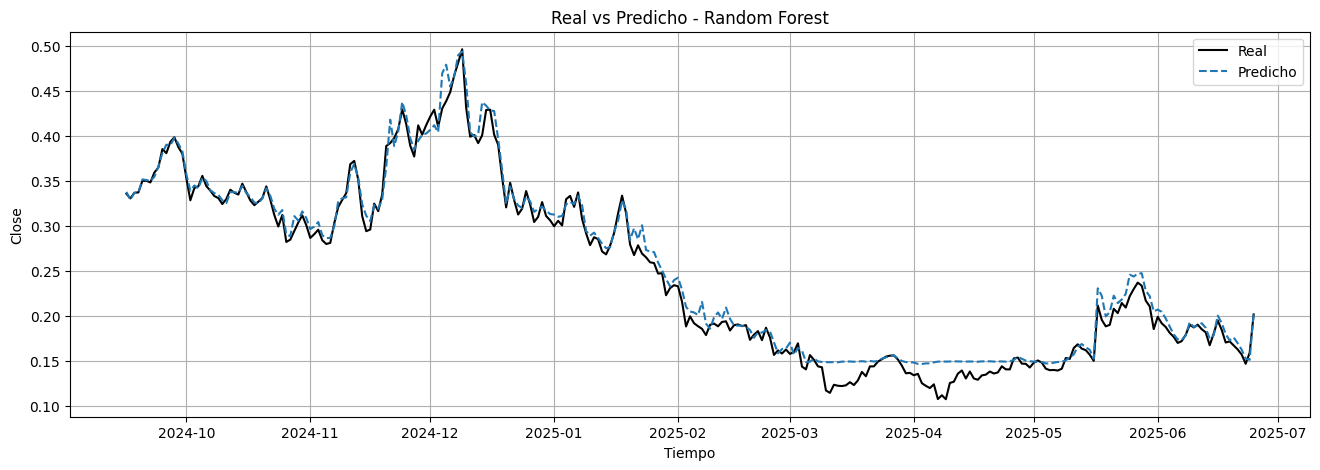

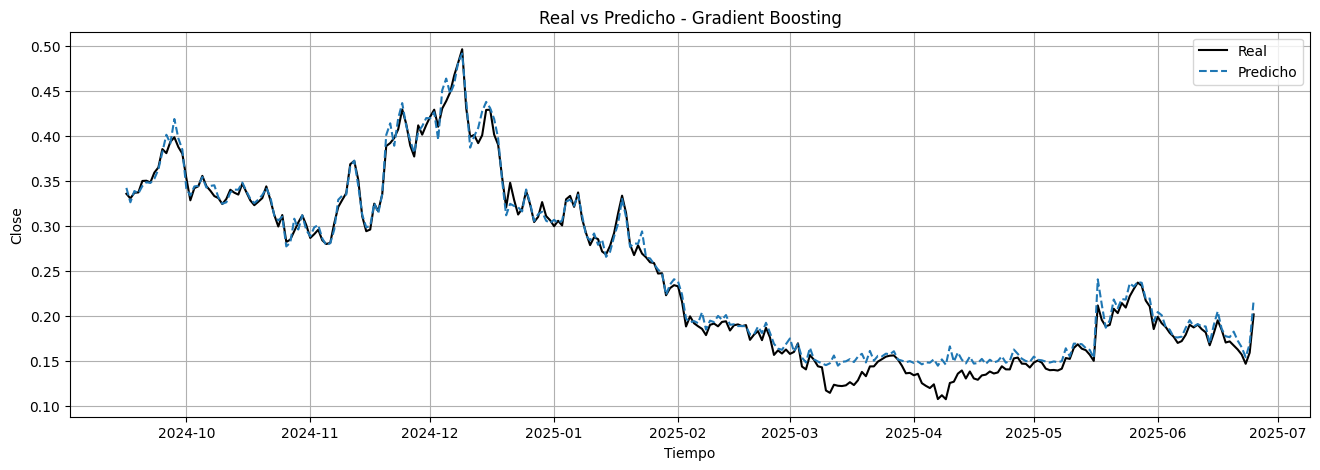

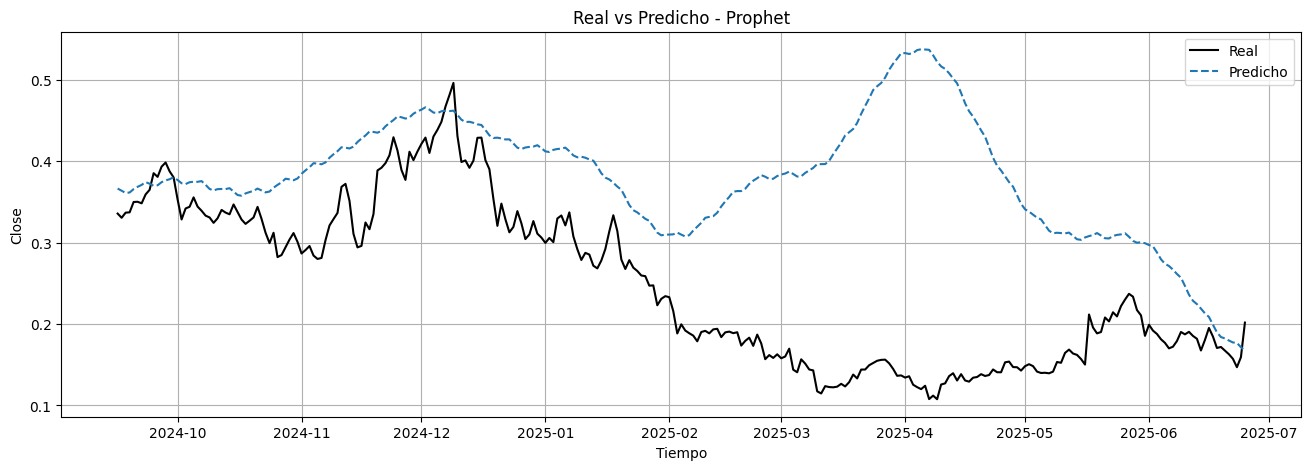

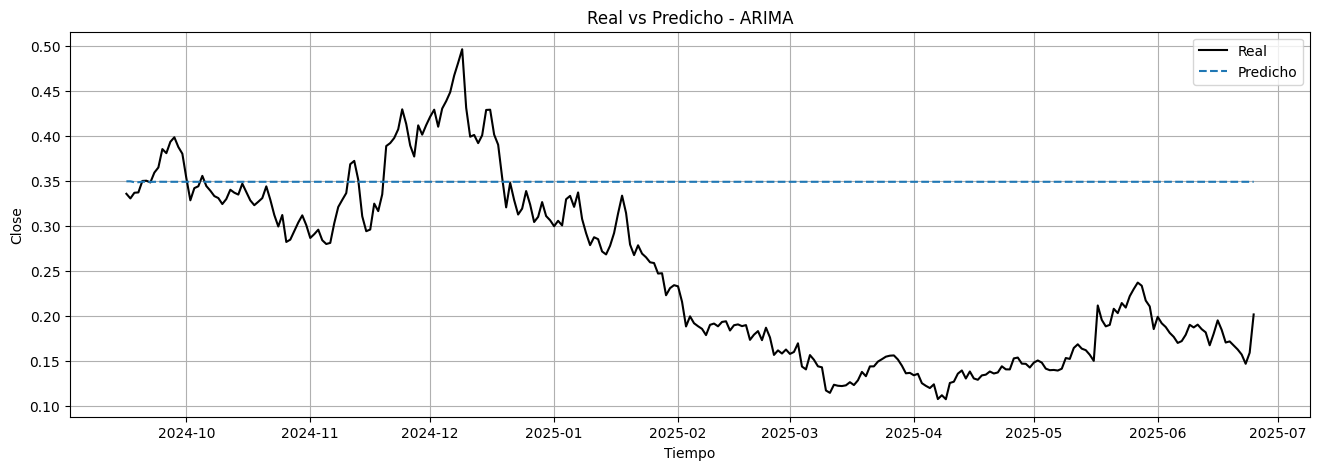

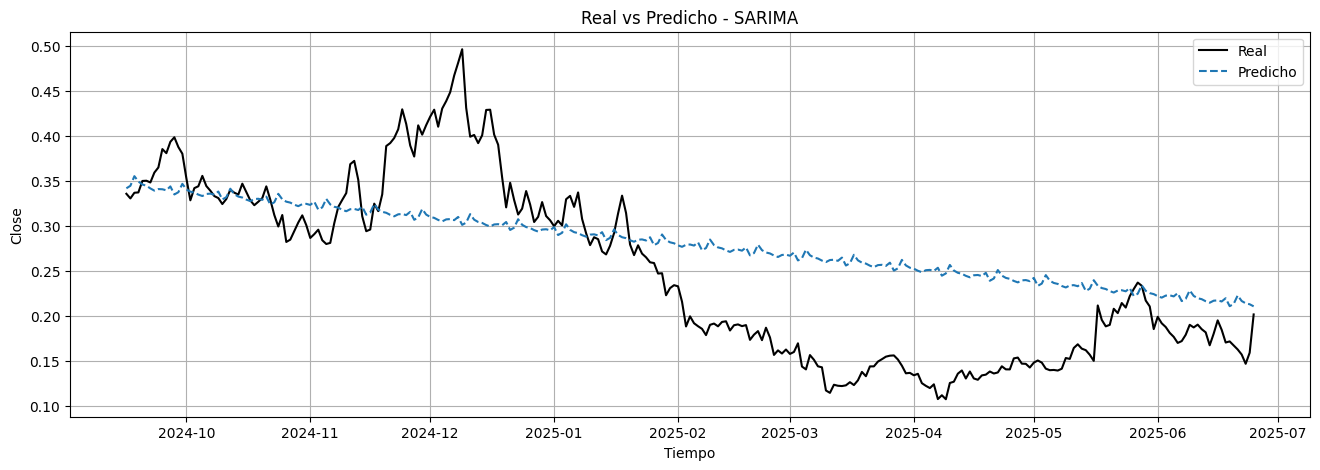

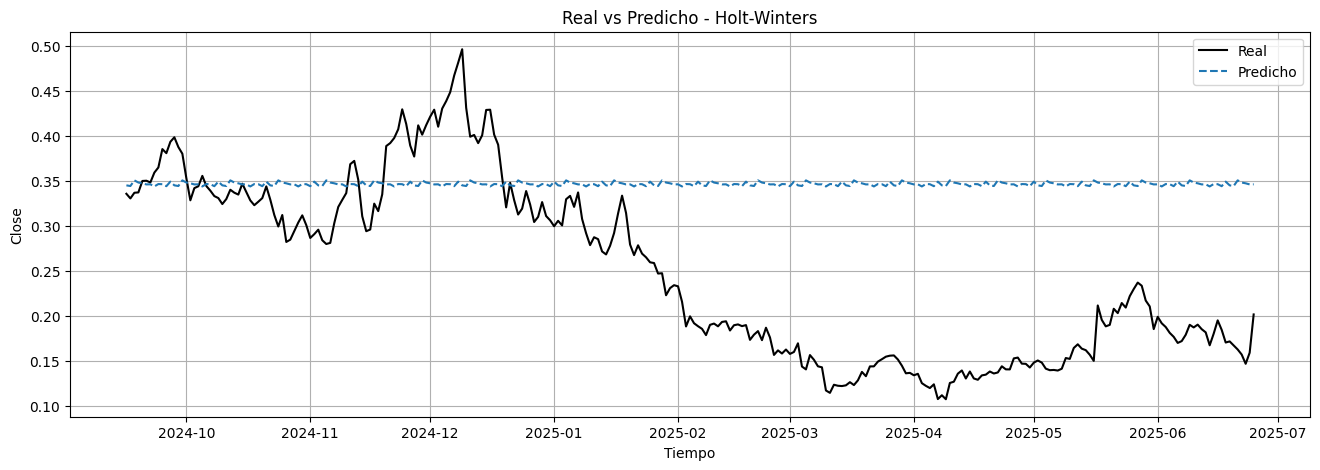

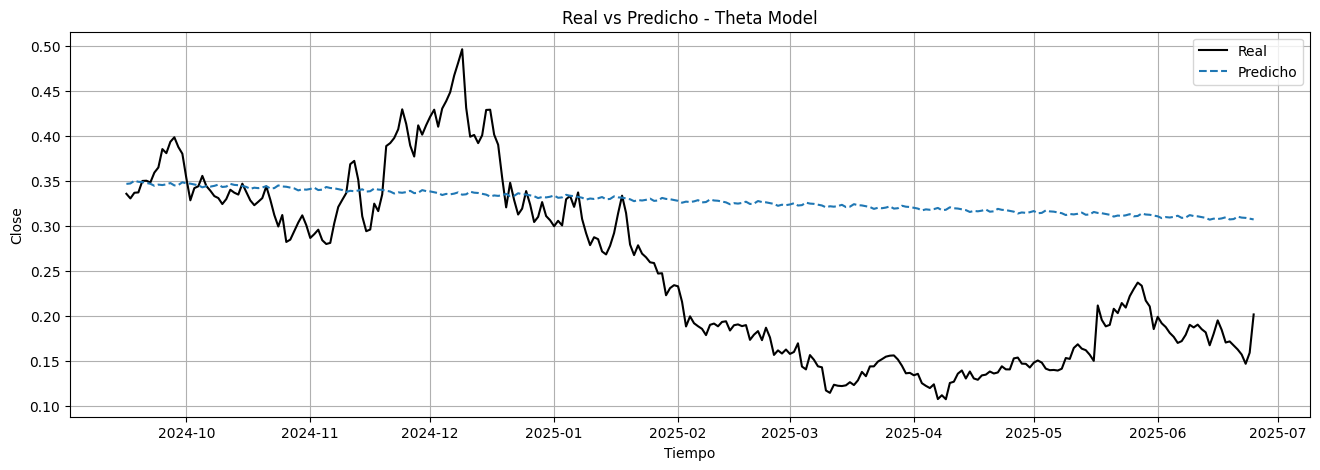

In [179]:
plot_predictions(y_test, y_pred_lgbm, "LightGBM")
plot_predictions(y_test, y_pred_xgb, "XGBoost")
plot_predictions(y_test, y_pred_cat, "CatBoost")
plot_predictions(y_test, y_pred_rf, "Random Forest")
plot_predictions(y_test, y_pred_gb, "Gradient Boosting")
plot_predictions(y_test, y_pred_prophet, "Prophet")
plot_predictions(y_test, y_pred_arima, "ARIMA")
plot_predictions(y_test, y_pred_sarima, "SARIMA")
plot_predictions(y_test, y_pred_hw, "Holt-Winters")
plot_predictions(y_test, y_pred_theta, "Theta Model")

# Redes Neuronales

Escalar datos

In [109]:
from sklearn.preprocessing import StandardScaler

In [110]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [111]:
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

In [112]:
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))

## MLP Simple

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [119]:
mlp_simple = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)
])

In [120]:
mlp_simple.compile(optimizer='adam', loss='mse')
mlp_simple.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=0)

In [121]:
y_pred_nn_scaled = mlp_simple.predict(X_test_scaled)
y_pred_nn = scaler_y.inverse_transform(y_pred_nn_scaled)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [272]:
mae, rmse, r2 = evaluate(y_test, y_pred_nn.flatten(), "MLP Simple")
results.append({"name": "MLP Simple", "MAE": mae, "RMSE": rmse, "R2": r2})


MLP Simple
MAE:  0.0210
RMSE: 0.0250
R²:   0.9340


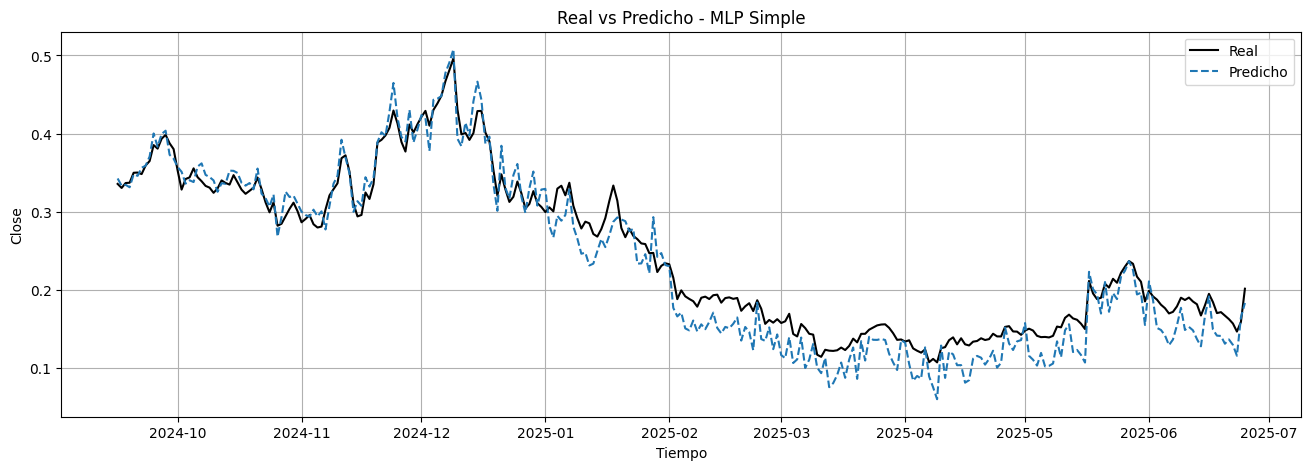

In [251]:
plot_predictions(y_test, y_pred_nn.flatten(), "MLP Simple")

## MlP Profunda

In [123]:
mlp_deep = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

In [124]:
mlp_deep.compile(optimizer='adam', loss='mse')
mlp_deep.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=0)

In [125]:
y_pred_deep_scaled = mlp_deep.predict(X_test_scaled)
y_pred_deep = scaler_y.inverse_transform(y_pred_deep_scaled)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [273]:
mae, rmse, r2 = evaluate(y_test, y_pred_deep.flatten(), "MLP Profunda")
results.append({"name": "MLP Profunda", "MAE": mae, "RMSE": rmse, "R2": r2})


MLP Profunda
MAE:  0.0129
RMSE: 0.0166
R²:   0.9709


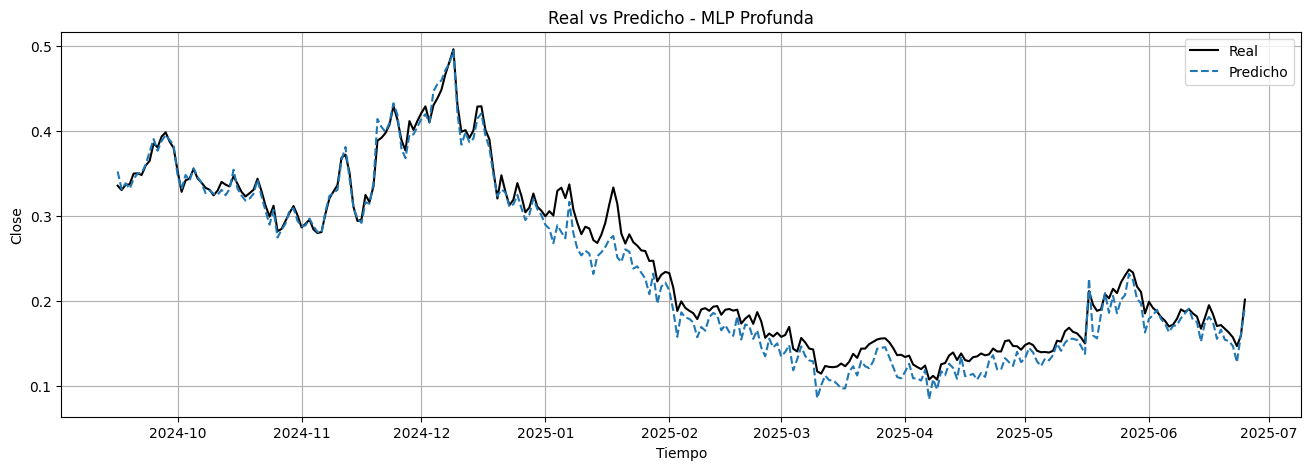

In [253]:
plot_predictions(y_test, y_pred_deep.flatten(), "MLP Profunda")

# Redes Neuronales Hardcore Series temporales

preparar secuencias

In [180]:
def create_sequences(X, y, seq_length=10):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:(i+seq_length)])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

In [181]:
seq_length = 10 

In [182]:
X_train_seq, y_train_seq = create_sequences(X_train.values, y_train.values, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test.values, y_test.values, seq_length)

In [183]:
print(X_train_seq.shape, y_train_seq.shape)
print(X_test_seq.shape, y_test_seq.shape)

(1121, 10, 20) (1121,)
(273, 10, 20) (273,)


## Escalar

In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [185]:
n_samples, n_timesteps, n_features = X_train_seq.shape

In [186]:
X_train_seq_reshaped = X_train_seq.reshape(-1, n_features)
X_test_seq_reshaped = X_test_seq.reshape(-1, n_features)

In [187]:
X_train_scaled = scaler_X.fit_transform(X_train_seq_reshaped).reshape(-1, seq_length, n_features)
X_test_scaled = scaler_X.transform(X_test_seq_reshaped).reshape(-1, seq_length, n_features)

In [188]:
y_train_scaled = scaler_y.fit_transform(y_train_seq.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test_seq.reshape(-1,1)).flatten()

## Graficas

In [214]:
def plot_predictions_red_neuronal(y_test, y_pred, name, index=None):
    plt.figure(figsize=(16,5))
    if index is not None:
        plt.plot(index, y_test, label='Real', color='black')
        plt.plot(index, y_pred, label='Predicho', linestyle='--')
    else:
        plt.plot(y_test, label='Real', color='black')
        plt.plot(y_pred, label='Predicho', linestyle='--')
    plt.title(f"Real vs Predicho - {name}")
    plt.xlabel("Tiempo")
    plt.ylabel("Close")
    plt.legend()
    plt.grid()
    plt.show()


## LSTM

In [215]:
from tensorflow.keras.layers import LSTM, Dense

In [216]:
model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(seq_length, n_features)),
    Dense(1)
])

In [217]:
model_lstm.compile(optimizer='adam', loss='mse')

In [218]:
model_lstm.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.6646
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0314
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0105
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0122
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0096
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0076
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0065
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0076
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0081
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0077
Epoch 16/50
36/

In [219]:
y_pred_lstm_scaled = model_lstm.predict(X_test_scaled)
y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm_scaled).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [274]:
mae, rmse, r2 = evaluate(y_test_seq, y_pred_lstm, "LSTM")
results.append({"name": "LSTM", "MAE": mae, "RMSE": rmse, "R2": r2})


LSTM
MAE:  0.0350
RMSE: 0.0403
R²:   0.8277


## GRU

In [201]:
from tensorflow.keras.layers import GRU

In [222]:
model_gru = Sequential([
    GRU(64, activation='tanh', input_shape=(seq_length, n_features)),
    Dense(1)
])

In [223]:
model_gru.compile(optimizer='adam', loss='mse')

In [224]:
model_gru.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.4315
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0240
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0148
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0121
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0107
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0095
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0126
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0075
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0223
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0089
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0078
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096
Epoch 16/50
36

In [225]:
y_pred_gru_scaled = model_gru.predict(X_test_scaled)
y_pred_gru = scaler_y.inverse_transform(y_pred_gru_scaled).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [275]:
mae, rmse, r2 = evaluate(y_test_seq, y_pred_gru, "GRU")
results.append({"name": "GRU", "MAE": mae, "RMSE": rmse, "R2": r2})


GRU
MAE:  0.0200
RMSE: 0.0254
R²:   0.9318


## TCN

In [229]:
from tcn import TCN

In [230]:
model_tcn = Sequential([
    TCN(64, activation='relu', input_shape=(seq_length, n_features)),
    Dense(1)
])

In [231]:
model_tcn.compile(optimizer='adam', loss='mse')

In [232]:
model_tcn.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 3.9635
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2112
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0940
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0575
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0405
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0326
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0314
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0312
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0255
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0137
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0128
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0087
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0106
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0097
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0072
Epoc

In [233]:
y_pred_tcn_scaled = model_tcn.predict(X_test_scaled)
y_pred_tcn = scaler_y.inverse_transform(y_pred_tcn_scaled).flatten()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


In [276]:
mae, rmse, r2 = evaluate(y_test_seq, y_pred_tcn, "TCN")
results.append({"name": "TCN", "MAE": mae, "RMSE": rmse, "R2": r2})


TCN
MAE:  0.0721
RMSE: 0.0915
R²:   0.1135


## Graficas

In [235]:
y_test_index = y_test.index[seq_length:]

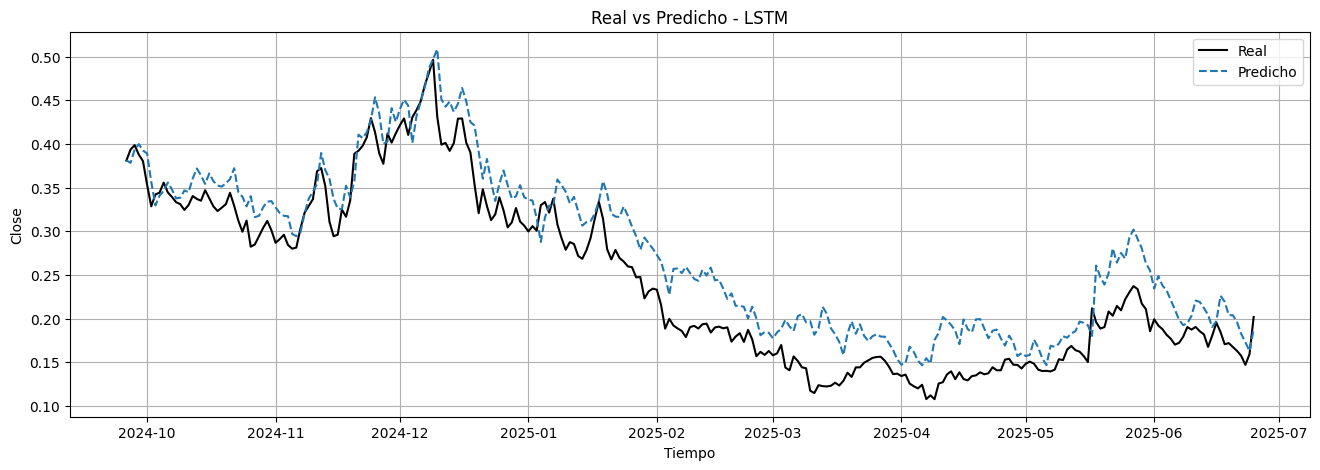

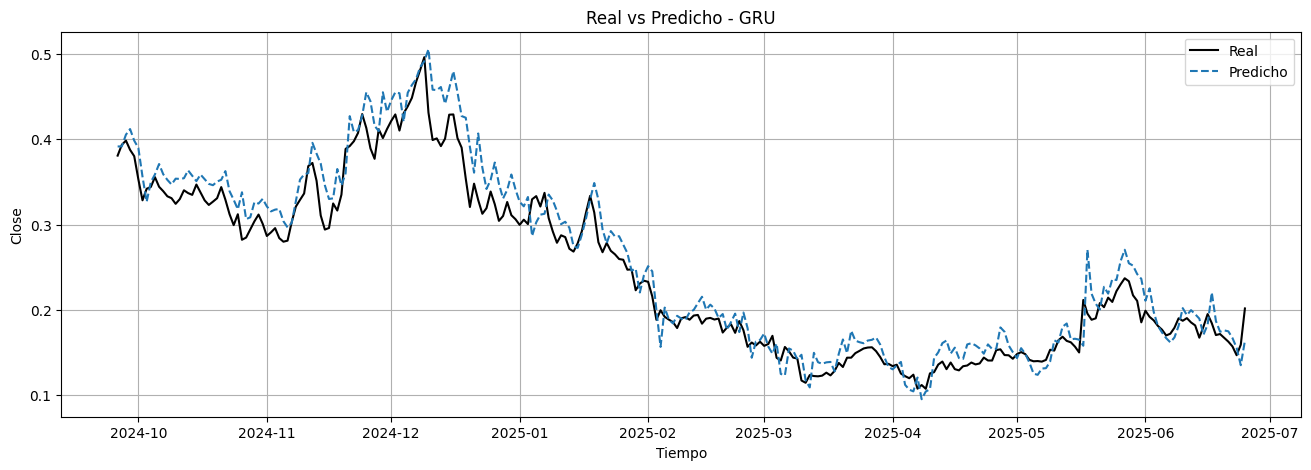

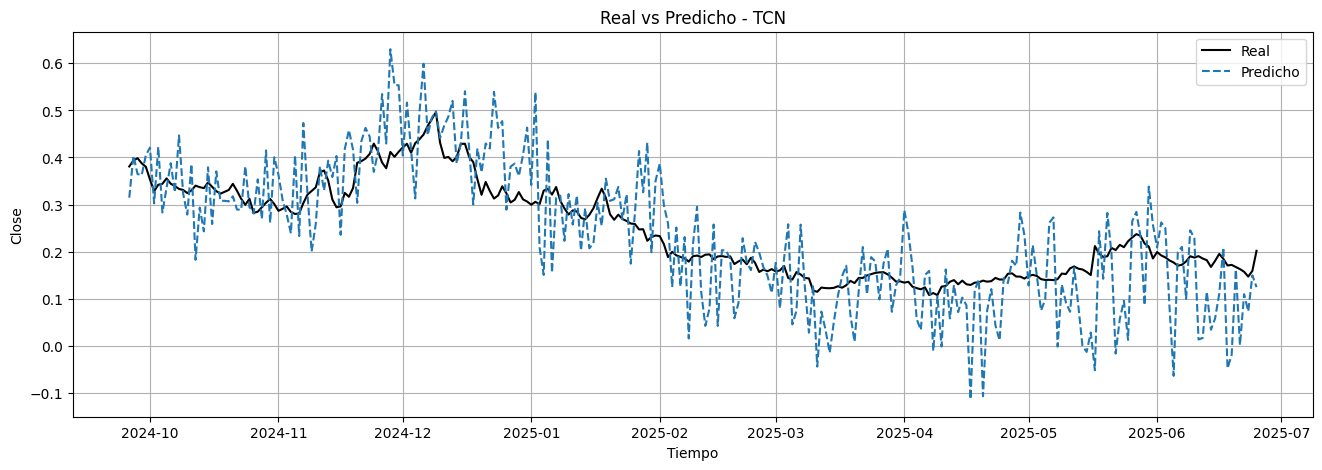

In [236]:
plot_predictions_red_neuronal(y_test_seq, y_pred_lstm, "LSTM", index=y_test_index)
plot_predictions_red_neuronal(y_test_seq, y_pred_gru, "GRU", index=y_test_index)
plot_predictions_red_neuronal(y_test_seq, y_pred_tcn, "TCN", index=y_test_index)

# Resulados

In [277]:
df_results = pd.DataFrame(results)

In [278]:
df_results_sorted = df_results.sort_values(by='RMSE')

In [279]:
df_results_sorted 

,name,MAE,RMSE,R2
4,Gradient Boosting,0.007945,0.011224,0.986735
1,XGBoost,0.008981,0.012312,0.984040
3,Random Forest,0.008992,0.012372,0.983882
0,LightGBM,0.009487,0.013548,0.980674
11,MLP Profunda,0.012945,0.016633,0.970870
2,CatBoost,0.020774,0.025022,0.934074
10,MLP Simple,0.020984,0.025041,0.933977
13,GRU,0.019978,0.025385,0.931764
12,LSTM,0.034979,0.040333,0.827746
7,SARIMA,0.062507,0.077141,0.373410


# Predecir el Futuro

In [325]:
X_full = X.copy()
y_full = y.copy()

In [326]:
best_model = GradientBoostingRegressor()
best_model.fit(X_full, y_full)

GradientBoostingRegressor()

## Configura fechas futuras y variables

Cuántos días a futuro quieres predecir

In [327]:
future_steps = 30

última fila historica

In [328]:
last_date = X_full.index[-1]
last_known_df = df.loc[[last_date]].copy()

In [329]:
future_predictions = []
df_temp = df.copy()  # para ir actualizando día a día

## Preparar el primer paso del loop

In [334]:
step = 1
pred_date = last_date + pd.Timedelta(days=step)

row_future = pd.DataFrame(index=[pred_date])
row_future['year'] = pred_date.year
row_future['month'] = pred_date.month
row_future['day'] = pred_date.day
row_future['day_of_week'] = pred_date.dayofweek
row_future['quarter'] = (pred_date.month - 1) // 3 + 1

## Añadir exógenas con ruido

In [335]:
for col in ['open', 'high', 'low', 'volume_log', 'marketCap_log']:
    last_val = df_temp.iloc[-1][col]
    noise = np.random.normal(0, 0.01)  # 1% de ruido
    row_future[col] = last_val * (1 + noise)

row_future['return'] = 0

## Calcular lags y rolling means

In [336]:
for lag in range(1, 8):
    if len(df_temp) >= lag:
        row_future[f'lag_{lag}'] = df_temp.iloc[-lag]['target']
    else:
        row_future[f'lag_{lag}'] = np.nan

row_future['rolling_mean_3'] = df_temp['target'].iloc[-3:].mean() if len(df_temp) >= 3 else df_temp['target'].mean()
row_future['rolling_mean_7'] = df_temp['target'].iloc[-7:].mean() if len(df_temp) >= 7 else df_temp['target'].mean()

## Predecir y actualizar histórico

In [337]:
X_future_row = row_future[features]
y_pred = best_model.predict(X_future_row)[0]

future_predictions.append((pred_date, y_pred))

new_row = row_future.copy()
new_row['target'] = y_pred
df_temp = pd.concat([df_temp, new_row])


## Iterar los pasos siguientes

In [338]:
for step in range(2, future_steps + 1):
    pred_date = last_date + pd.Timedelta(days=step)

    row_future = pd.DataFrame(index=[pred_date])
    row_future['year'] = pred_date.year
    row_future['month'] = pred_date.month
    row_future['day'] = pred_date.day
    row_future['day_of_week'] = pred_date.dayofweek
    row_future['quarter'] = (pred_date.month - 1) // 3 + 1

    for col in ['open', 'high', 'low', 'volume_log', 'marketCap_log']:
        last_val = df_temp.iloc[-1][col]
        noise = np.random.normal(0, 0.01)
        row_future[col] = last_val * (1 + noise)

    row_future['return'] = 0

    for lag in range(1, 8):
        if len(df_temp) >= lag:
            row_future[f'lag_{lag}'] = df_temp.iloc[-lag]['target']
        else:
            row_future[f'lag_{lag}'] = np.nan

    row_future['rolling_mean_3'] = df_temp['target'].iloc[-3:].mean() if len(df_temp) >= 3 else df_temp['target'].mean()
    row_future['rolling_mean_7'] = df_temp['target'].iloc[-7:].mean() if len(df_temp) >= 7 else df_temp['target'].mean()

    X_future_row = row_future[features]
    y_pred = best_model.predict(X_future_row)[0]

    future_predictions.append((pred_date, y_pred))

    new_row = row_future.copy()
    new_row['target'] = y_pred
    df_temp = pd.concat([df_temp, new_row])


## Convertir predicciones a Series

In [339]:
y_pred_future = pd.Series(
    [pred for date, pred in future_predictions],
    index=[date for date, pred in future_predictions]
)

## Graficar histórico + predicciones futuras

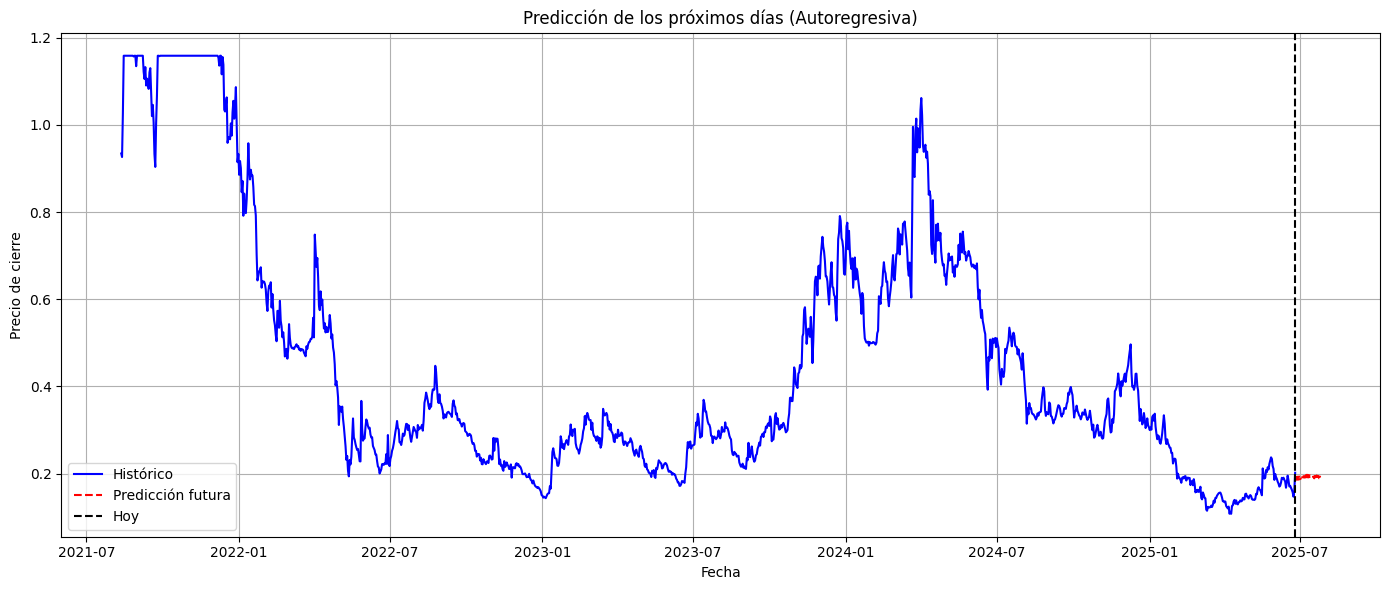

In [340]:
plt.figure(figsize=(14, 6))
plt.plot(y_full.index, y_full, label='Histórico', color='blue')
plt.plot(y_pred_future.index, y_pred_future, label='Predicción futura', color='red', linestyle='--')
plt.axvline(y_full.index[-1], color='black', linestyle='--', label='Hoy')
plt.title("Predicción de los próximos días (Autoregresiva)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Gráfico solo predicciones futuras

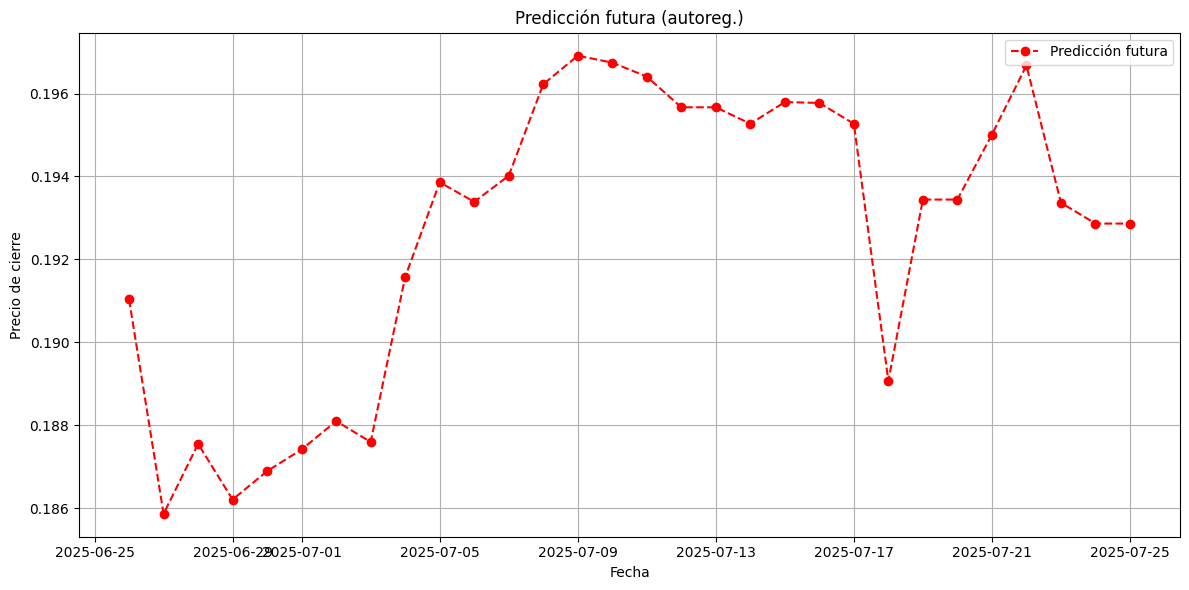

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(
    y_pred_future.index,
    y_pred_future.values,
    label='Predicción futura',
    color='red',
    linestyle='--',
    marker='o'
)
plt.title("Predicción futura (autoreg.)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()